In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
import numba
import anndata
from scipy import sparse
import os,time,datetime,sys,pickle
from sklearn.model_selection import train_test_split

In [2]:
import umap
from sklearn.manifold import TSNE

from scipy import stats as st
from collections import OrderedDict
from collections import defaultdict
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sknetwork.clustering import Louvain

from scipy.io import mmread
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph

import tarfile as tar
import csv
import gzip
import os
import scipy.io

In [3]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.2.4 scikit-learn==0.24.1 statsmodels==0.14.0.dev794+g5b586d714 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


In [4]:
path1= '/Users/dsoler/Desktop/Stat ML for Genomics/TBI Project/bTBI 2'
path2= '/Users/dsoler/Desktop/Stat ML for Genomics/TBI Project/Sham 2'

bTBI = sc.read_10x_mtx(path1, cache=True)
sham = sc.read_10x_mtx(path2, cache=True)

... reading from cache file cache/Users-dsoler-Desktop-Stat ML for Genomics-TBI Project-bTBI 2-matrix.h5ad
... reading from cache file cache/Users-dsoler-Desktop-Stat ML for Genomics-TBI Project-Sham 2-matrix.h5ad


In [5]:
bTBI.obs['bTBI']=True
sham.obs['bTBI']=False
bTBI.obs['condition'] = 'bTBI'
sham.obs['condition'] = 'sham'

# 01. General Preprocessing #

In [6]:
adata = bTBI.concatenate(sham)

/Applications/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [7]:
QC_metrics = sc.pp.calculate_qc_metrics(adata)

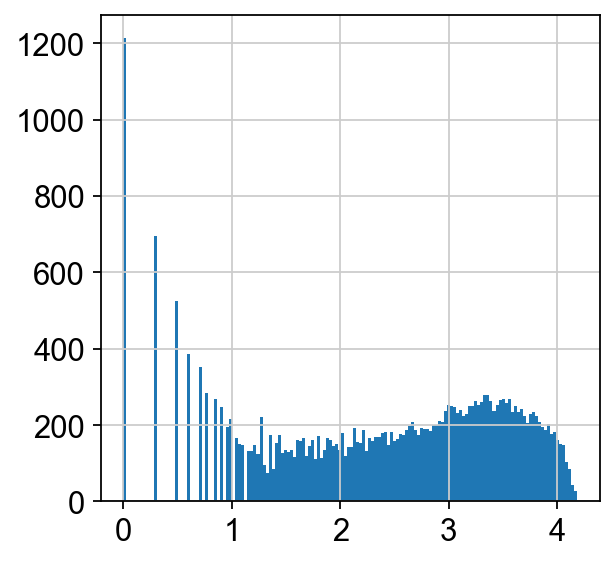

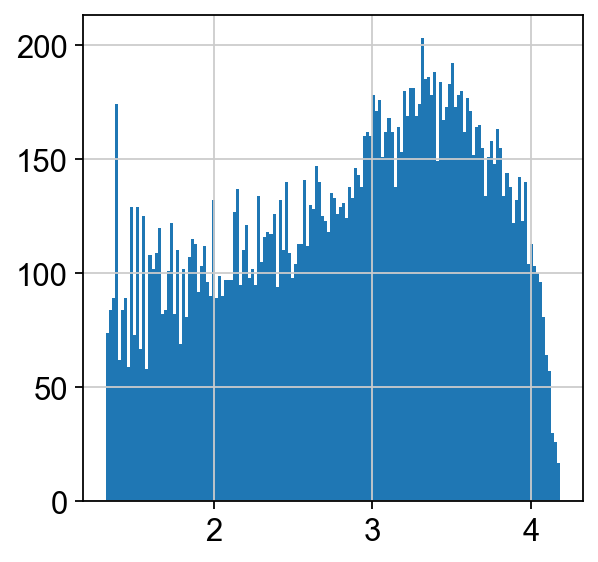

In [8]:
cells_per_gene = QC_metrics[1]['n_cells_by_counts']
cells_per_gene = cells_per_gene[cells_per_gene > 0]
filtered_cells_per_gene = cells_per_gene[cells_per_gene > 20]
plt.figure(1)
histogram = plt.hist(np.log10(cells_per_gene), 150)
plt.figure(2)
histogram = plt.hist(np.log10(filtered_cells_per_gene), 150)

In [9]:
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.filter_cells(adata, min_genes=200)

filtered out 11860 genes that are detected in less than 20 cells


In [10]:
median_lib_size = np.median(QC_metrics[0]['total_counts'])
sc.pp.normalize_total(adata, target_sum=median_lib_size)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [11]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var["highly_variable"]]

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


# 02. Clustering #

In [12]:
sc.pp.pca(adata, n_comps = 10, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata, knn=True)

computing PCA
    on highly variable genes
    with n_comps=10
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)


In [13]:
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.tl.louvain(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:03)


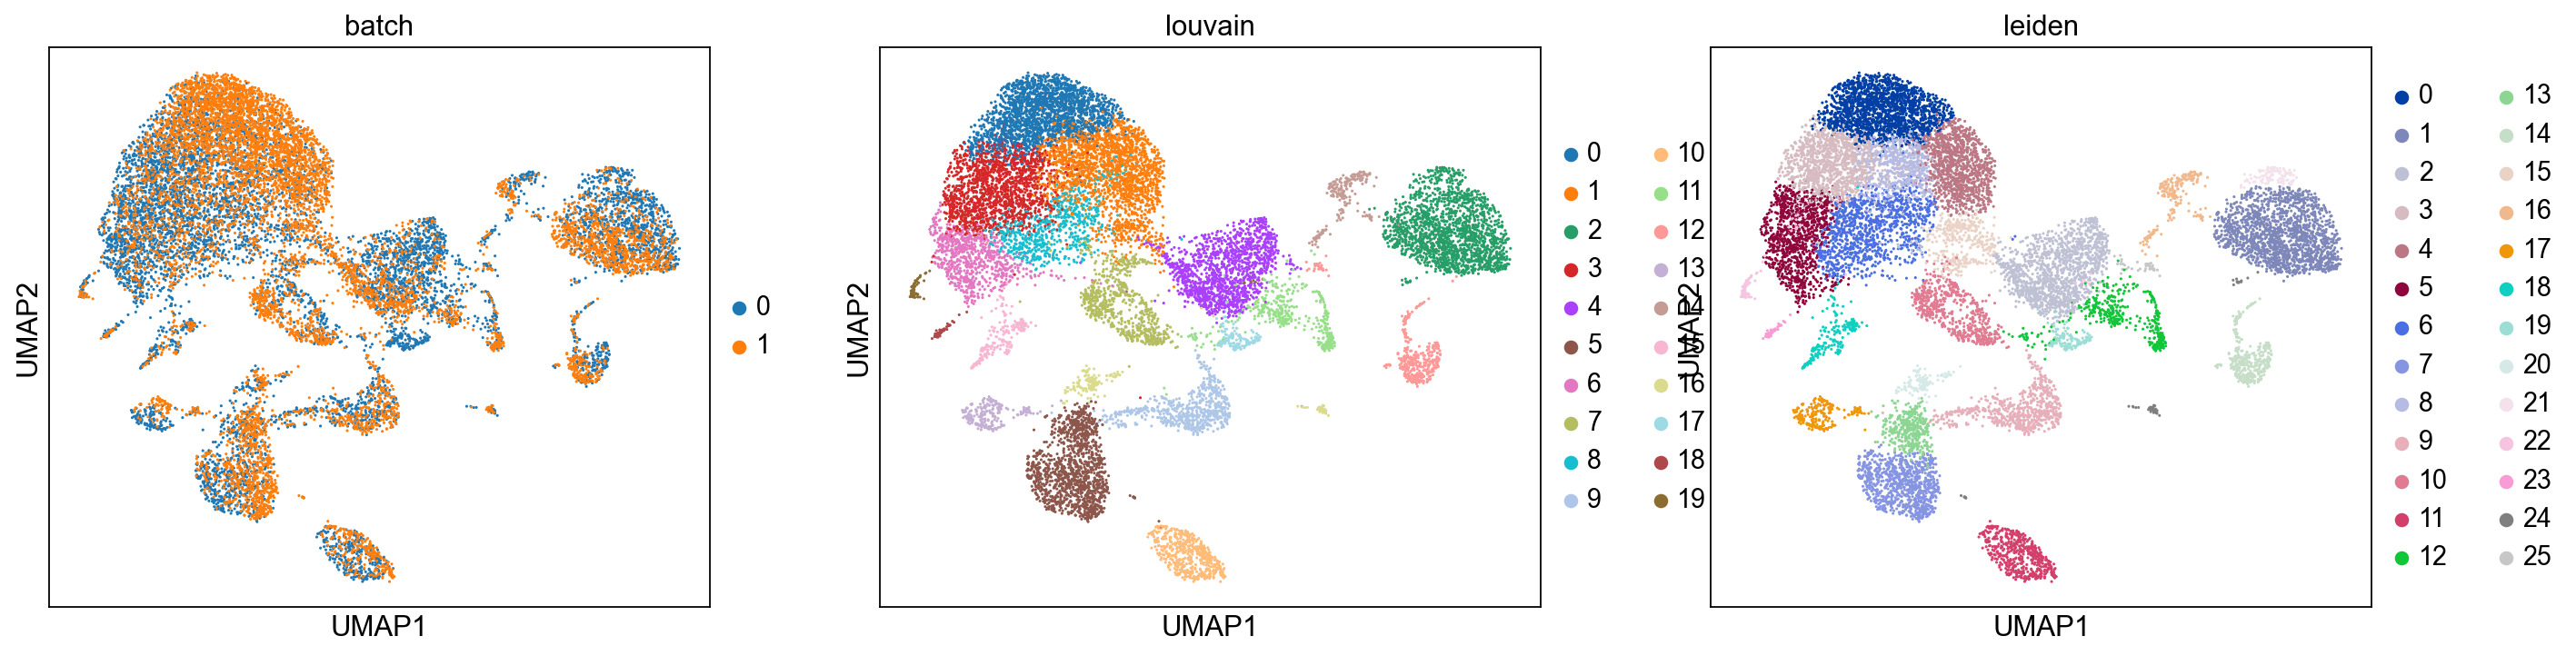

In [14]:
sc.settings.set_figure_params(figsize=(6,5))
sc.pl.umap(adata, color = ['batch','louvain', 'leiden'])

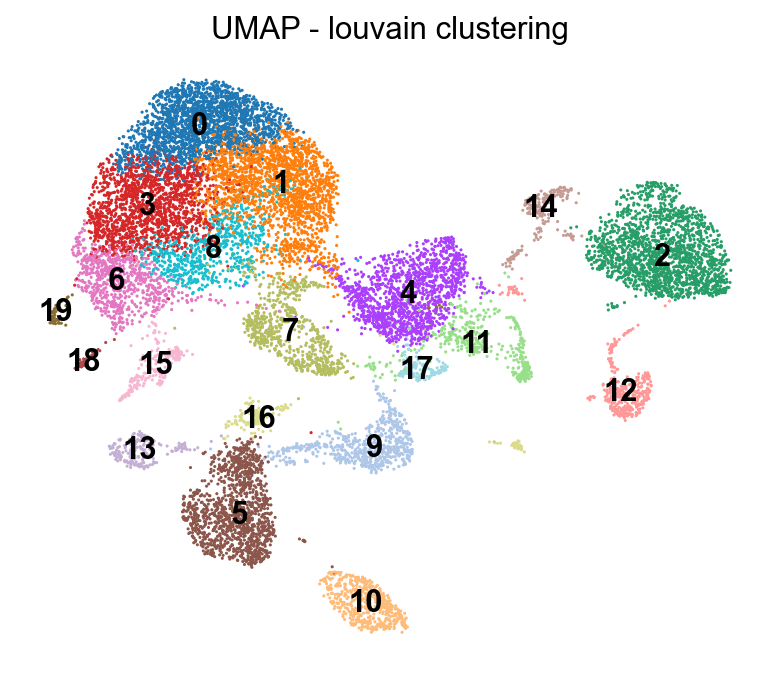

In [15]:
sc.settings.set_figure_params(figsize=(6,5))
sc.pl.umap(adata, color = ['louvain'], legend_loc='on data', frameon = False, title = "UMAP - louvain clustering")

# 03. Marker Genes #

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


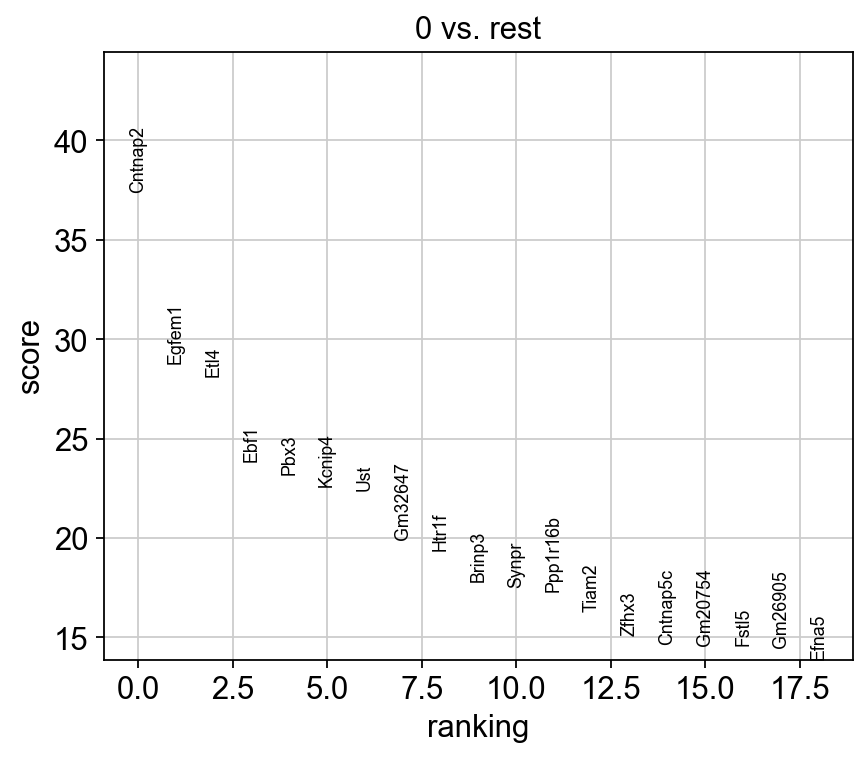

In [16]:
sc.tl.rank_genes_groups(adata, groupby='louvain', groups=['0'], method='wilcoxon') #paper uses this test
sc.pl.rank_genes_groups(adata, n_genes=19, sharey=False)
result = adata.uns['rank_genes_groups']
DEGs = result['names'].dtype.names
DEGs = result['names']

In [17]:
print(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20))

           0
0    Cntnap2
1     Egfem1
2       Etl4
3       Ebf1
4       Pbx3
5     Kcnip4
6        Ust
7    Gm32647
8      Htr1f
9     Brinp3
10     Synpr
11  Ppp1r16b
12     Tiam2
13     Zfhx3
14  Cntnap5c
15   Gm20754
16     Fstl5
17   Gm26905
18     Efna5
19       Tnr


In [18]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})

df

0_n            0_p
0     Cntnap2  2.576977e-306
1      Egfem1  4.861021e-182
2        Etl4  2.990152e-174
3        Ebf1  1.115166e-125
4        Pbx3  4.095517e-119
...       ...            ...
1995   mt-Co2  1.819808e-252
1996   Slc8a1  7.039890e-299
1997   mt-Co1  1.198057e-304
1998  mt-Atp6   0.000000e+00
1999   mt-Co3   0.000000e+00

[2000 rows x 2 columns]

    using 'X_pca' with n_pcs = 10
Storing dendrogram info using `.uns['dendrogram_louvain']`
categories: 0, 1, 2, etc.
var_group_labels: 0


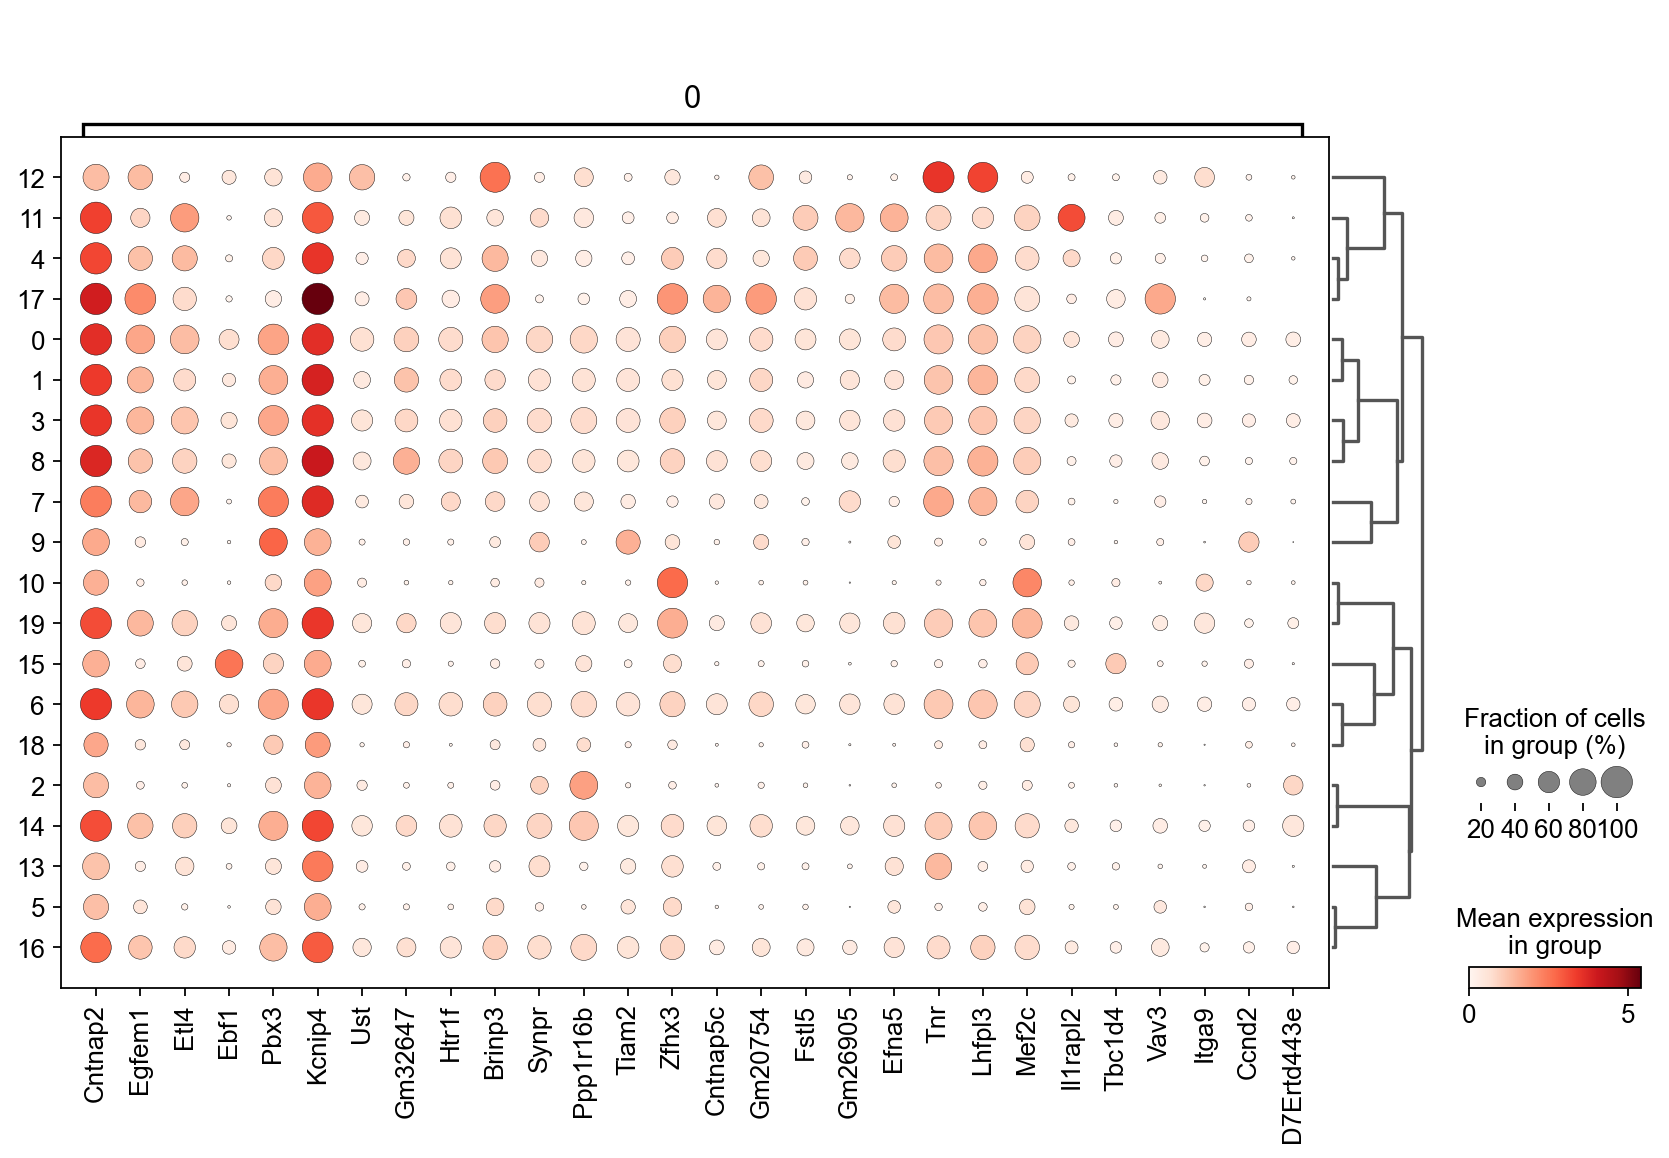

In [19]:
sc.pl.rank_genes_groups_dotplot(adata, key='rank_genes_groups', n_genes=28)

In [20]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.25, min_fold_change=0.25)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 0.25, max_out_group_fraction: 0.5


In [21]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({group + '_' + key[:]: result[key][group]
                for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
df

0_names    0_pvals_adj  0_logfoldchanges        1_names    1_pvals_adj  \
0     Cntnap2  1.717985e-303          1.590263         Kcnip4  1.420377e-262   
1      Egfem1  8.101702e-180          1.391875  C130073E24Rik  2.384528e-200   
2        Etl4  4.271646e-172          1.222683        Arhgap6  1.868915e-193   
3        Ebf1  8.578201e-124          1.557234        Fam19a2  2.686114e-155   
4        Pbx3  2.925369e-117          0.943800        Col25a1  1.734017e-149   
...       ...            ...               ...            ...            ...   
1995   mt-Co2  6.066027e-250         -1.867105        mt-Cytb  5.745645e-210   
1996   Slc8a1  2.815956e-296         -3.442320         mt-Co2  2.285803e-248   
1997   mt-Co1  5.990285e-302         -1.884533         mt-Co1  1.730487e-251   
1998  mt-Atp6   0.000000e+00         -1.740850        mt-Atp6  9.113105e-291   
1999   mt-Co3   0.000000e+00         -1.903729         mt-Co3   0.000000e+00   

      1_logfoldchanges  2_names  2_pvals_adj  2_logfoldchanges  3_names  ...  \
0             1.522531     Plp1          0.0          4.190149  Cntnap2  ...   
1             1.677828    Pde4b          0.0          3.809922   Kcnip4  ...   
2             1.454526      Mbp          0.0          5.491205     Etl4  ...   
3             1.310308     St18          0.0          7.173266  mt-Atp6  ...   
4             1.262728    Edil3          0.0          4.819975  mt-Cytb  ...   
...                ...      ...          ...               ...      ...  ...   
1995         -1.871386    Grip1          0.0         -3.591597    Erbb4  ...   
1996         -1.887729  Cntnap2          0.0         -2.650536    Fmnl2  ...   
1997         -1.712105   Kcnip4          0.0         -2.709547     Zeb2  ...   
1998         -1.704200   Frmd4a          0.0         -3.273479    Mast4  ...   
1999         -1.821277    Nrxn1          0.0         -2.794857   Slc8a1  ...   

      16_logfoldchanges  17_names  17_pvals_adj  17_logfoldchanges  18_names  \
0              3.654519     Kcnc2  1.570304e-79           5.653388    mt-Nd1   
1              3.016934     Ntng1  5.177948e-78           5.611045    mt-Co3   
2              3.175528    Kcnip4  5.177948e-78           3.610673    mt-Nd4   
3              2.982362     Hdac9  5.177948e-78           3.737764    mt-Co2   
4              4.028314     Zmat4  1.039876e-75           4.206563   mt-Cytb   
...                 ...       ...           ...                ...       ...   
1995          -0.527582     Synpr  2.510321e-18          -3.301221    Srgap2   
1996          -0.468494      Sgcd  1.366400e-18          -2.493458     Grip1   
1997          -0.868502     Erbb4  9.653118e-20          -2.965524     Pde4b   
1998          -0.728053     Ptprt  4.153850e-22          -2.863189     Frmd5   
1999          -1.084240      Pbx3  5.828153e-29          -3.133879    Frmd4a   

      18_pvals_adj  18_logfoldchanges  19_names  19_pvals_adj  \
0     3.025485e-44           6.690929    Inpp5d  2.385496e-26   
1     3.025485e-44           6.606745      Hexb  1.787762e-20   
2     3.025485e-44           6.514613      Fli1  1.072983e-19   
3     3.025485e-44           6.732162   Apbb1ip  2.291355e-19   
4     3.025485e-44           6.598129     Pde3b  4.352473e-19   
...            ...                ...       ...           ...   
1995  9.559492e-14          -2.767039     Pacrg  3.473816e-03   
1996  5.521202e-14          -2.906829      Nfib  2.767538e-03   
1997  1.728487e-14          -2.815821     Edil3  2.064143e-03   
1998  6.857688e-15          -2.938287     Frmd5  1.647738e-03   
1999  5.100926e-20          -3.396937     Npas3  2.699085e-04   

      19_logfoldchanges  
0              4.350577  
1              3.461877  
2              3.877147  
3              3.825616  
4              2.609057  
...                 ...  
1995          -2.126609  
1996          -3.254476  
1997          -2.080975  
1998          -1.005662  
1999          -3.170856  

[2000 rows x 60 columns]

In [83]:
df[df['1_names']== 'Gfap'] # cluster 1 with Sox10 this is expected so we do have NSCs in that cluster, matching genes 

0_names  0_pvals_adj  0_logfoldchanges 1_names  1_pvals_adj  \
765  Gm7480     0.858052         -3.994372    Gfap     0.953645   

     1_logfoldchanges  2_names  2_pvals_adj  2_logfoldchanges  3_names  ...  \
765         -2.183074  Clec4a3     0.988191         -0.969048  Dennd1c  ...   

     16_logfoldchanges  17_names 17_pvals_adj  17_logfoldchanges  18_names  \
765           0.064118    Lmntd1      0.99888          -0.897158    Pik3r6   

    18_pvals_adj  18_logfoldchanges  19_names 19_pvals_adj  19_logfoldchanges  
765      0.99296         -23.442459      Irf7     0.999352           2.216047  

[1 rows x 60 columns]

In [23]:
df[df['5_names']== 'Vim'] # same here 

0_names  0_pvals_adj  0_logfoldchanges 1_names  1_pvals_adj  \
607   Upk1b     0.988242          -3.93335    Klf4     0.996133   

     1_logfoldchanges        2_names  2_pvals_adj  2_logfoldchanges   3_names  \
607         -1.817955  6030468B19Rik     0.988191         -1.037668  AU021092   

     ...  16_logfoldchanges  17_names 17_pvals_adj  17_logfoldchanges  \
607  ...           1.220425     Sp140      0.99888          -0.103656   

     18_names 18_pvals_adj  18_logfoldchanges  19_names 19_pvals_adj  \
607      Cd44      0.99296         -22.316685     Ston1     0.999352   

     19_logfoldchanges  
607           1.711698  

[1 rows x 60 columns]

In [24]:
df[df['16_names']== 'Abcg2'] # same here 

0_names   0_pvals_adj  0_logfoldchanges 1_names   1_pvals_adj  \
1860   Gfra1  2.998812e-27         -2.430337     Mal  4.953354e-18   

      1_logfoldchanges   2_names   2_pvals_adj  2_logfoldchanges 3_names  ...  \
1860         -1.720397  Tnfrsf19  8.093214e-37         -2.434099   Nxph1  ...   

      16_logfoldchanges  17_names 17_pvals_adj  17_logfoldchanges  18_names  \
1860          -2.304961     Irak2     0.552955          -2.302749      Rffl   

     18_pvals_adj  18_logfoldchanges  19_names 19_pvals_adj  19_logfoldchanges  
1860      0.00343          -3.684092   Plekhg3     0.999352         -26.605867  

[1 rows x 60 columns]

In [25]:
df[df['5_names']== 'Vim'] #same here

0_names  0_pvals_adj  0_logfoldchanges 1_names  1_pvals_adj  \
607   Upk1b     0.988242          -3.93335    Klf4     0.996133   

     1_logfoldchanges        2_names  2_pvals_adj  2_logfoldchanges   3_names  \
607         -1.817955  6030468B19Rik     0.988191         -1.037668  AU021092   

     ...  16_logfoldchanges  17_names 17_pvals_adj  17_logfoldchanges  \
607  ...           1.220425     Sp140      0.99888          -0.103656   

     18_names 18_pvals_adj  18_logfoldchanges  19_names 19_pvals_adj  \
607      Cd44      0.99296         -22.316685     Ston1     0.999352   

     19_logfoldchanges  
607           1.711698  

[1 rows x 60 columns]

# 04. Neural Stem Cells (NSCs) # 
### Based on the literature Abcg2 and Vim are NSC marker genes #

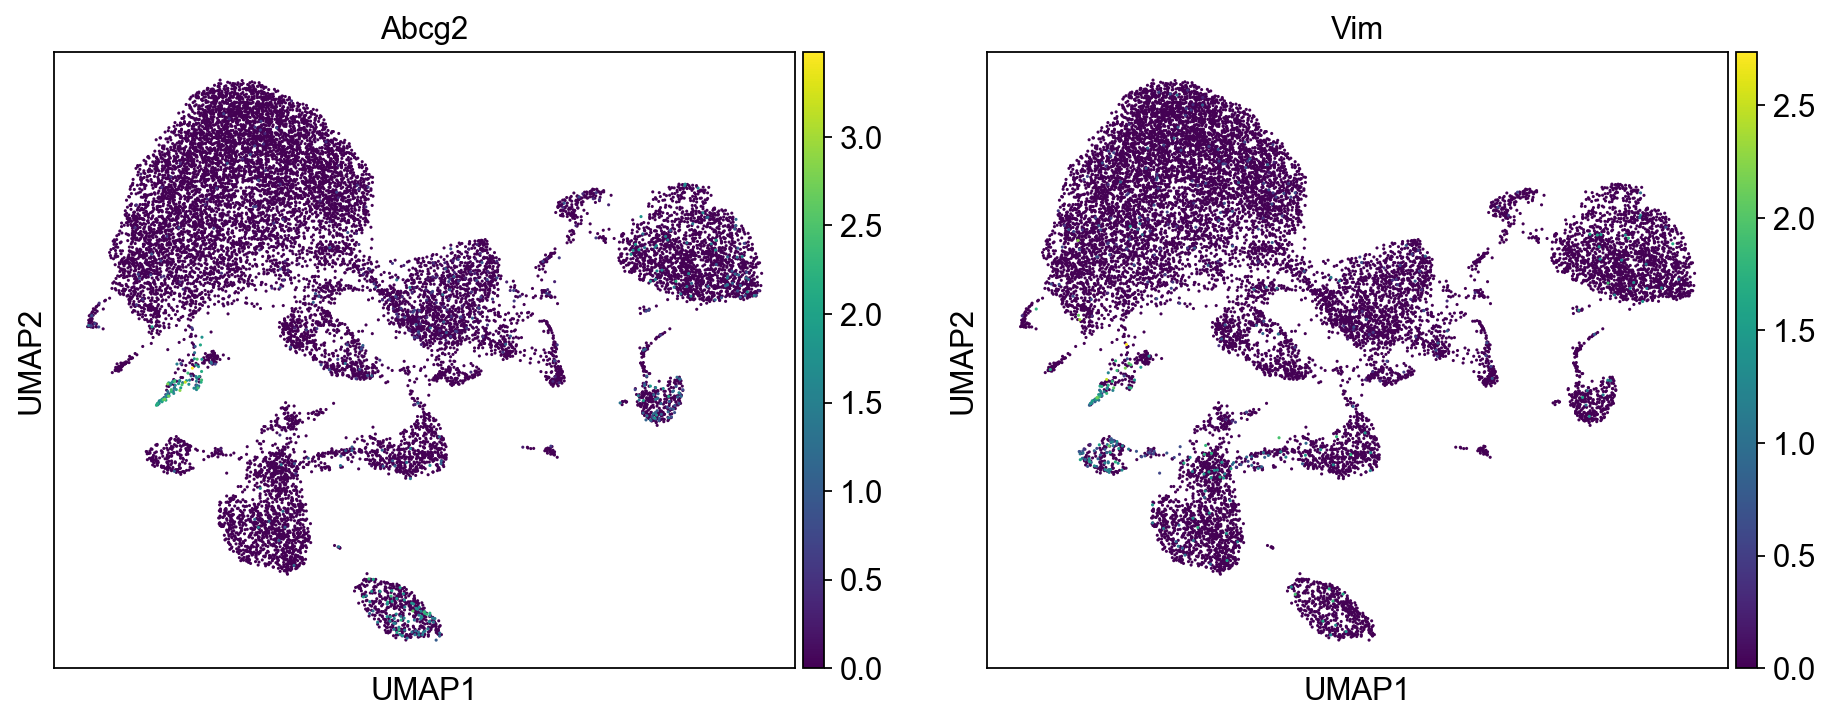

In [26]:
sc.pl.umap(adata, color=['Abcg2', 'Vim']) #looks like they are cluster 15

In [27]:
# adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', 'NSC', 'Neuron', '7', '8', '9', '10/Ery', '11', '12',
       #'13', '14', '15', '16', '17', '18', '19']

In [28]:
labels_neuron = ['6','1', '8', '3', '0', '7', '4','19', '9', '11', '17']
labels_astrocyte = ['5','16']
labels_nsc =['15']
labels_microglia= ['10']
labels_oligodendrocyte = ['14','2']
labels_endothelial_mural = ['13']
labels_OPC = ['12']
labels_ependymal = ['18']

In [97]:
adata.obs['Cells'] = ['Neuron' if i in labels_neuron
                             else 'Astrocyte' if i in labels_astrocyte
                             else 'NSC' if i in labels_nsc 
                             else 'Microglia' if i in labels_microglia
                             else 'Oligodendrocyte' if i in labels_oligodendrocyte
                             else 'Endothelial-Mural' if i in labels_endothelial_mural
                             else 'OPC' if i in labels_OPC
                             else 'Epen' if i in labels_ependymal
                             else 'Others' for i in adata.obs['louvain']]

In [98]:
#adata.obs['louvain'] = adata.obs['Cells']
%matplotlib tk

In [99]:
sc.settings.set_figure_params(figsize=(6,6))

sc.pl.umap(adata, color=['louvain', 'Cells'], 
        frameon=False, legend_loc='on data')

In [100]:
nsc = adata[adata.obs['Cells'] == 'NSC', :]
root_cell = nsc.obs_names[147]

nsc.obs['root'] = ['root_NSC' if i == root_cell in nsc.obs_names
                             else ' ' for i in nsc.obs_names]
nsc

<ipython-input-100-45d0e3be967d>:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  nsc.obs['root'] = ['root_NSC' if i == root_cell in nsc.obs_names


AnnData object with n_obs × n_vars = 198 × 2000
    obs: 'bTBI', 'condition', 'batch', 'n_genes', 'leiden', 'louvain', 'Cells', 'root'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'louvain', 'batch_colors', 'louvain_colors', 'leiden_colors', 'rank_genes_groups', 'dendrogram_louvain', 'rank_genes_groups_filtered', 'Cells_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'distances', 'connectivities'

In [101]:
sc.pl.umap(nsc, color=['root'], legend_loc='on data') #plot with start cell

In [102]:
sc.pl.umap(nsc, color=['Abcg2', 'Vim'], legend_loc='on data') #our stem cell thus root cells

In [39]:
#print([x for x in np.sort(adata.obsm['X_umap'], axis=0)])

In [40]:
# astros = adata[adata.obs['Cells'] == 'Astrocyte_NSC', :]
# epen  = adata[adata.obs['Cells'] == 'Ependymal', :]
# opc = adata[adata.obs['Cells'] == 'OPC', :]
# oligo= adata[adata.obs['Cells'] == 'Oligodendrocyte', :]

In [41]:
adata.obs

bTBI condition batch  n_genes leiden louvain  \
AAACCCAAGCTGAAAT-1-0   True      bTBI     0     3860      6       3   
AAACCCAAGTCATACC-1-0   True      bTBI     0     1617      1       2   
AAACCCACAAGCGGAT-1-0   True      bTBI     0     3756     24      16   
AAACCCACATGACTTG-1-0   True      bTBI     0     1350      1       2   
AAACCCAGTATTAAGG-1-0   True      bTBI     0     1911      7       5   
...                     ...       ...   ...      ...    ...     ...   
TTTGTTGGTAAGATTG-1-1  False      sham     1     2925     17      13   
TTTGTTGGTACAGAGC-1-1  False      sham     1     3567      2       4   
TTTGTTGGTATGCTTG-1-1  False      sham     1     2352     12      11   
TTTGTTGGTCGTTGGC-1-1  False      sham     1     3048      3       3   
TTTGTTGTCATTGCGA-1-1  False      sham     1     3713      0       0   

                                  Cells  
AAACCCAAGCTGAAAT-1-0             Neuron  
AAACCCAAGTCATACC-1-0    Oligodendrocyte  
AAACCCACAAGCGGAT-1-0          Astrocyte  
AAACCCACATGACTTG-1-0    Oligodendrocyte  
AAACCCAGTATTAAGG-1-0          Astrocyte  
...                                 ...  
TTTGTTGGTAAGATTG-1-1  Endothelial-Mural  
TTTGTTGGTACAGAGC-1-1             Neuron  
TTTGTTGGTATGCTTG-1-1             Neuron  
TTTGTTGGTCGTTGGC-1-1             Neuron  
TTTGTTGTCATTGCGA-1-1             Neuron  

[15272 rows x 7 columns]

In [42]:
print(np.flatnonzero(adata.obs['Cells']  == 'NSC')[68]) #very little stem cells 

3709


# 05. Palantir #
Note: There are not many NSCs (which is usually the case). Now that we know what genes are active in other cells after a bTBI (DEG analysis done in another notebook) we want to the see phate of the NSCs. Explore routes such as NSC --> Astrocyte , NSC --> Neuron , NSC --> Oligodendrocytes

In [43]:
#sc.pp.neighbors(adata, n_neighbors=30, use_rep='X', method='gauss')

In [44]:
import palantir
import seaborn as sns
import warnings

%matplotlib inline

sns.set_style('ticks')
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [73]:
pca_projections = pd.DataFrame(adata.obsm['X_pca'], index=adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [74]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

In [75]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


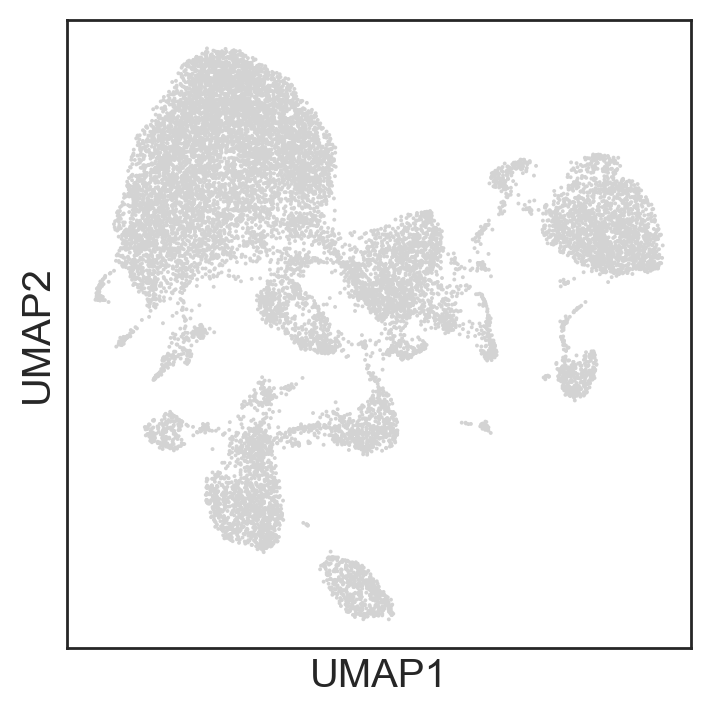

In [76]:
sc.pl.embedding(adata, basis='umap')

Creating a UMAP that only has the cell_types of interest (Astro, Neuron, Oligo)

In [85]:
# neuron = adata[adata.obs['Cells'] == 'Neuron', :]
# oligo = adata[adata.obs['Cells'] == 'Oligodendrocyte', :]
# astro = adata[adata.obs['Cells'] == 'Astrocyte', :]

In [84]:
#sc.pl.embedding(neuron, oligo, astro, basis='umap') trying to only plot these

In [49]:
adata.layers['MAGIC_imputed_data'] = palantir.utils.run_magic_imputation(adata, dm_res)

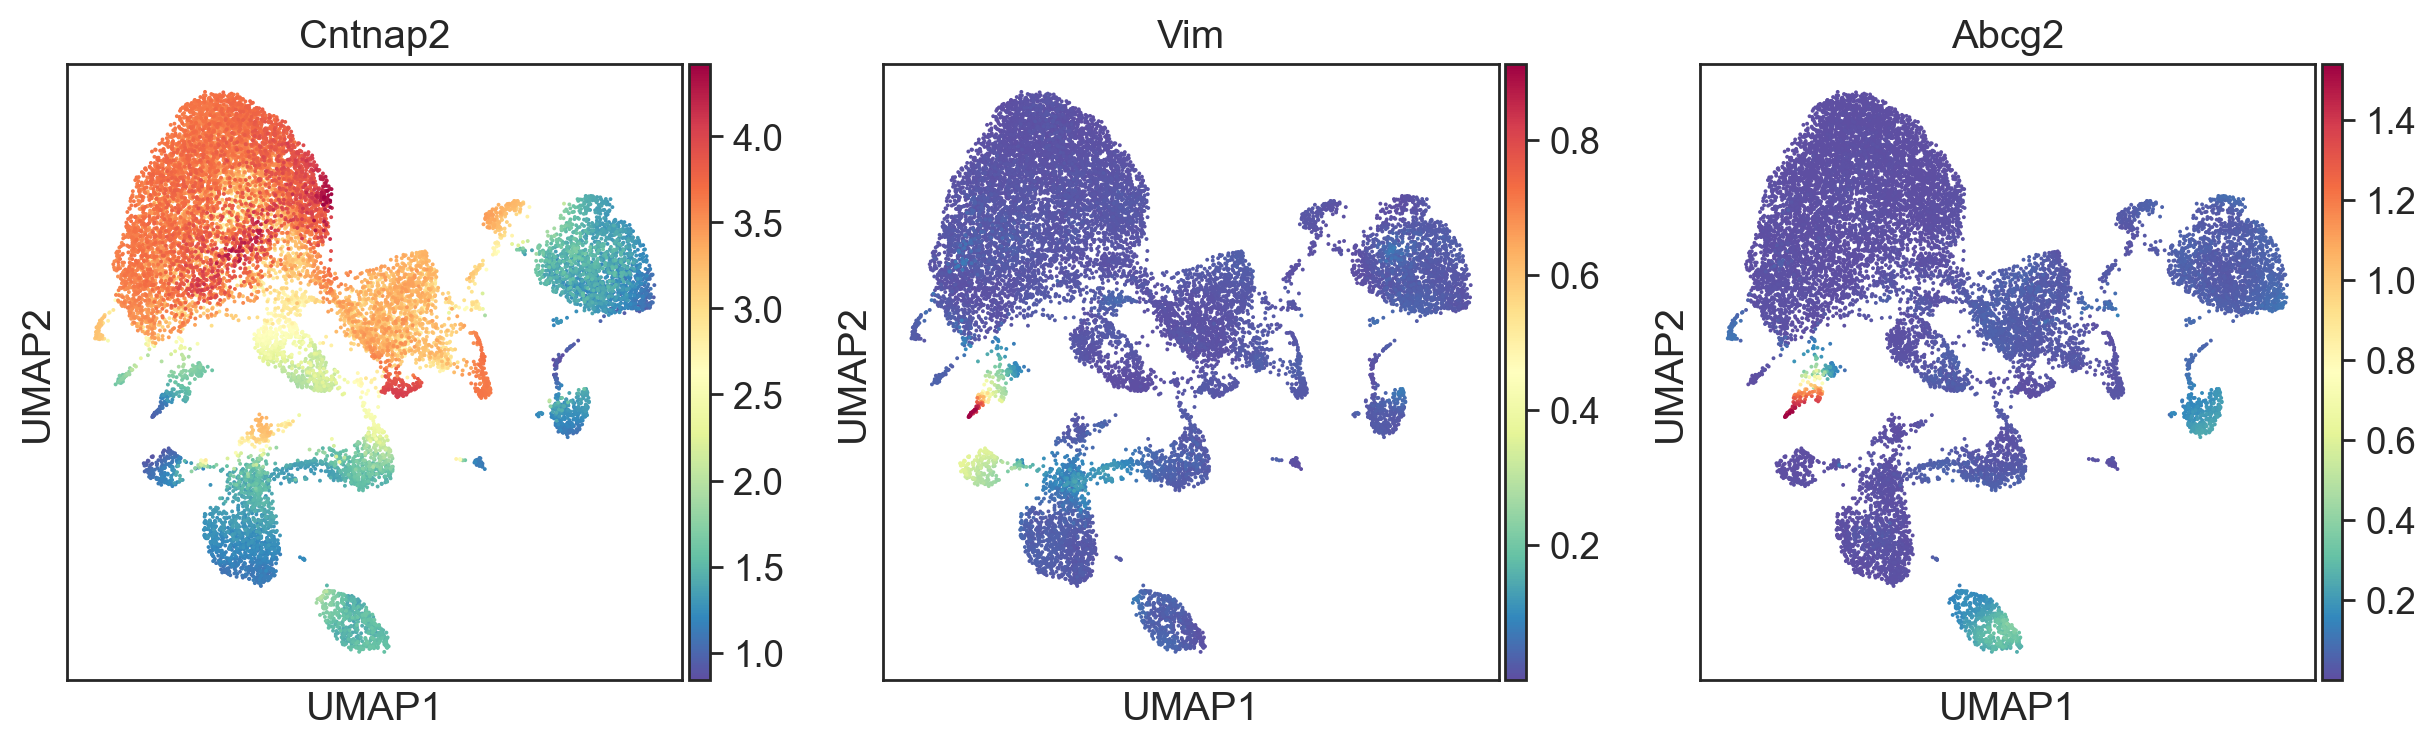

In [50]:
sc.pl.embedding(adata, basis='umap', layer='MAGIC_imputed_data',
               color=['Cntnap2', 'Vim', 'Abcg2']) #Cntnap2 is a Neuron marker gene while the other two are for NSCs

In [51]:
umap = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names)

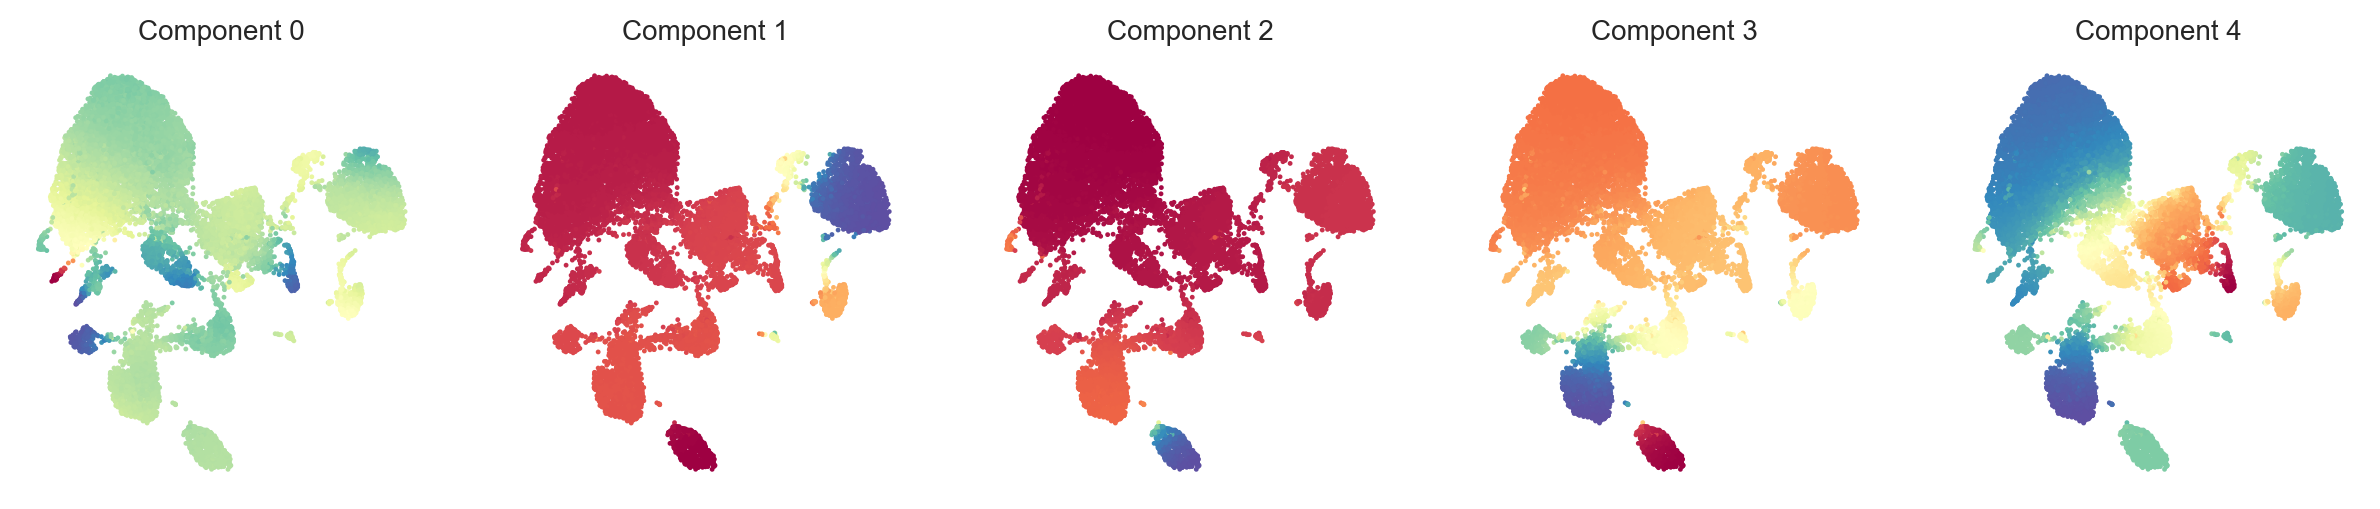

In [52]:
palantir.plot.plot_diffusion_components(umap, dm_res)

In [53]:
#terminal states should be Neuron, Oligodendrocytes and Glia
neuron = adata[adata.obs['Cells'] == 'Neuron', :]
oligo = adata[adata.obs['Cells'] == 'Oligodendrocyte', :]
astro = adata[adata.obs['Cells'] == 'Astrocyte', :]

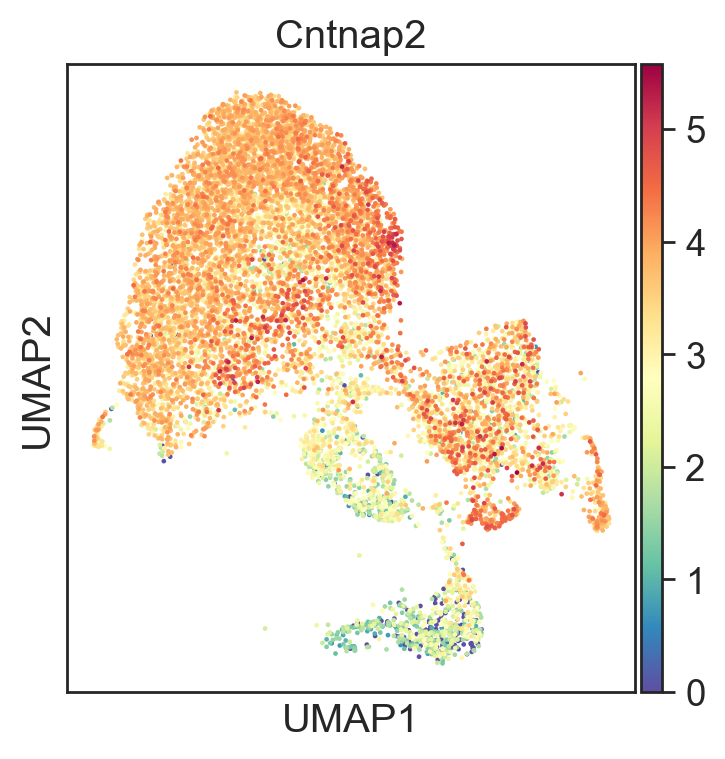

In [54]:
sc.pl.umap(neuron, color=['Cntnap2'], legend_loc='on data')

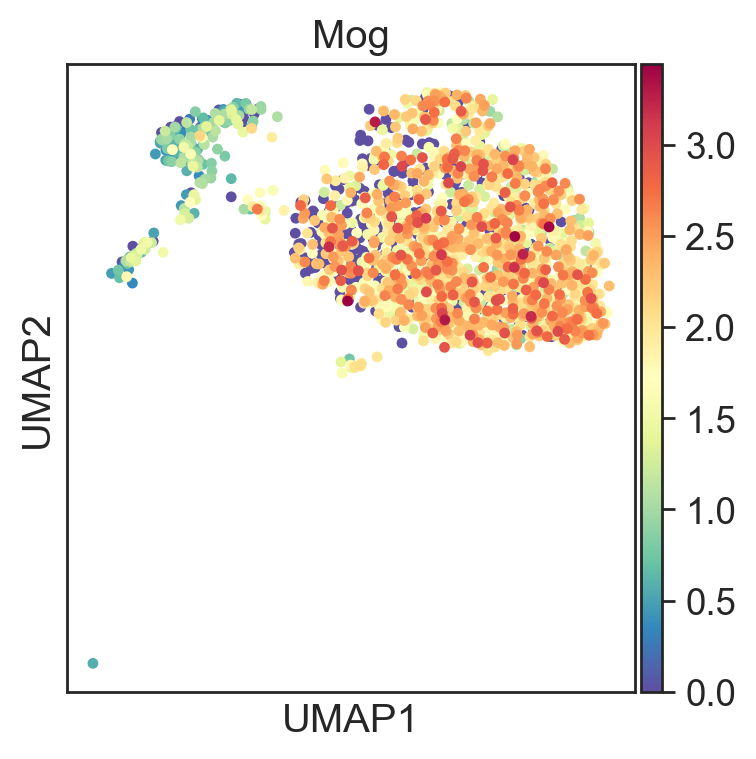

In [55]:
sc.pl.umap(oligo, color=['Mog'], legend_loc='on data')

In [56]:
astro.obs_names[150] #getting cell id for termiinal states

'ATTTCTGTCGGCCCAA-1-0'

In [57]:
terminal_states = pd.Series(['Neuron', 'Oligodendrocyte', 'Astrocyte'],  #confused about series titles 
                           index=['AACCACAGTCCTGTTC-1-0', 'ACTACGACACACCTTC-1-0', 'ATTTCTGTCGGCCCAA-1-0'])

In [58]:
root_cell = nsc.obs_names[147] #from above 
pr_res = palantir.core.run_palantir(ms_data, root_cell, num_waypoints=500, terminal_states=terminal_states.index) #terminal_states=terminal_states.index

Sampling and flocking waypoints...
Time for determining waypoints: 0.016660567124684653 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.36552989880243936 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


/Applications/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [103]:
palantir.plot.plot_palantir_results(pr_res, umap) #remove islands and only focus on cells that come from NSCs

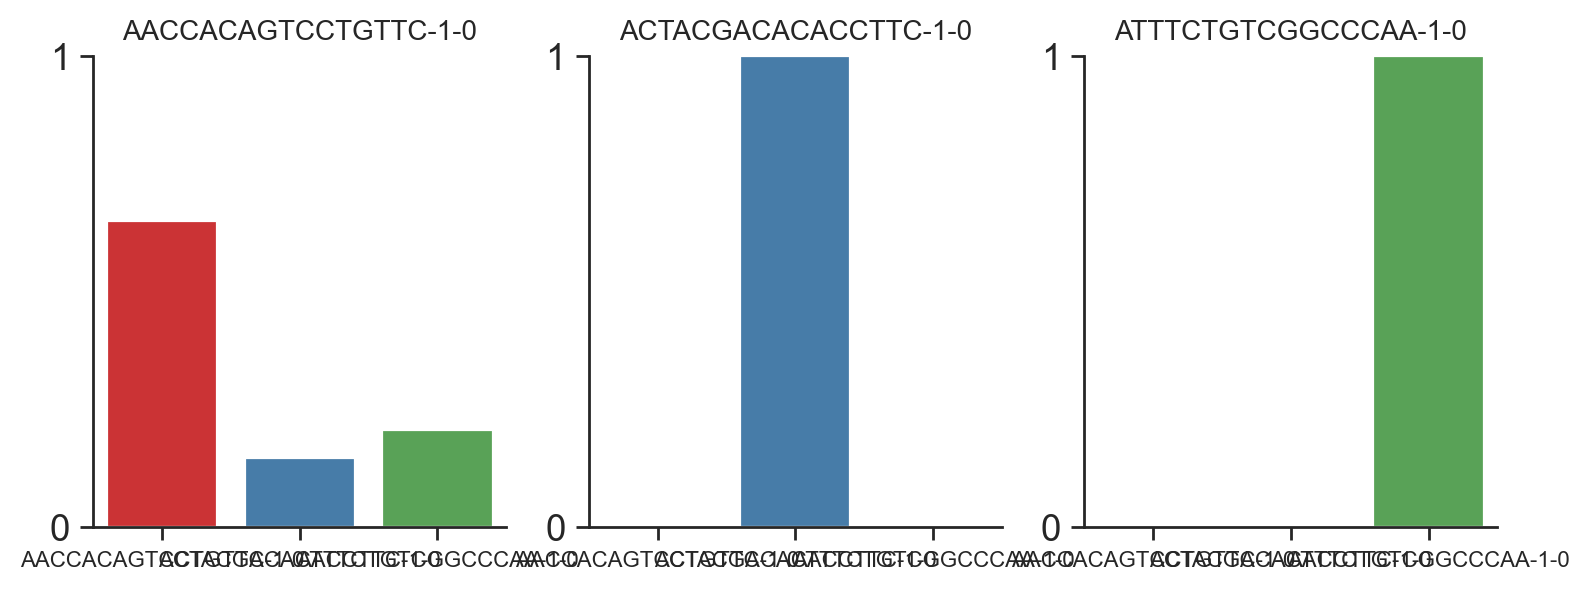

In [87]:
cells = ['AACCACAGTCCTGTTC-1-0', 'ACTACGACACACCTTC-1-0', 'ATTTCTGTCGGCCCAA-1-0']
palantir.plot.plot_terminal_state_probs(pr_res, cells) 

Compare all the maps, from dpt, GAT, Palantir (talk a lot about it in discussion) 